# Calculating Temporal Averages with GeoCAT-comp vs Xarray

With temporally large datasets, computing seasonal and annual averages are a great ways to summarize the data and make it easier to manage and understand. You may want to take hourly, daily, or monthly data and compute seasonal (3 month time spans) or annual averages.

## Challenges
When using data that has a daily or finer resolution (e.g. hourly), calculating an annual average is simple. Every day and hour has the same length, so an unweighted average will work.

But when using data that is monthly, things can get a bit tricky. Not every month is created equal. February has 28 or 29 days and March has 31 days. Since monthly data has one value for each month, those points can't be averaged in the usual way. A weighted average is needed.

While it is tempting to quickly compute monthly to annual averages with `Xarray`'s `resample` or `groupby` functions, we need to be careful to specify the weights. Unfortunately, `Xarray` doesn't support weighted `resample` or `groupby` at the time this post was created.

Below is a plot showing the difference between computing an annual average from monthly data using the incorrect unweighted average and the correct weighted average.

# ADD PLOT

### Imports

In [2]:
import intake
import intake_esm
url = intake_esm.tutorial.get_url('google_cmip6')
print(url)
cat = intake.open_esm_datastore(url)
cat
cat.df.head()
unique = cat.unique()
unique


cat_subset = cat.search(
    experiment_id=["historical", "ssp585"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
)

cat_subset

cat.esmcat.aggregation_control
dset_dict = cat_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)

https://raw.githubusercontent.com/intake/intake-esm/main/tutorial-catalogs/GOOGLE-CMIP6.json

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


ESMDataSourceError: Failed to load dataset with key='CMIP.CCCma.CanESM5.historical.Oyr.gn'
                 You can use `cat['CMIP.CCCma.CanESM5.historical.Oyr.gn'].df` to inspect the assets/files for this key.
                 

### Read in and format data

In [158]:
# Open a netCDF data file using xarray default engine and load the data into xarrays
ds = xr.open_dataset(gdf.get("netcdf_files/ts.nc"), decode_times=False)
# get temperature variable
temp = ds.T

Working with dates can be tricky. The dates in this dataset are represented as integers which stand for the number of months since January 1979. It is easier to work with `datetime` objects, so we do that conversion here. Check out the [`cftime` API](https://unidata.github.io/cftime/api.html#cftime.num2pydate) for more information.

### The incorrect way to compute seasonal averages from monthly data

It's easy to compute and unweighted average using `xarray` functionality; however, this generates inaccurate results. Here is what the ***incorrect*** way of doing this looks like.

In [140]:
season_avg = sst.groupby('time.season').mean()

In [141]:
winter_avg_bad = season_avg.isel(season=0)

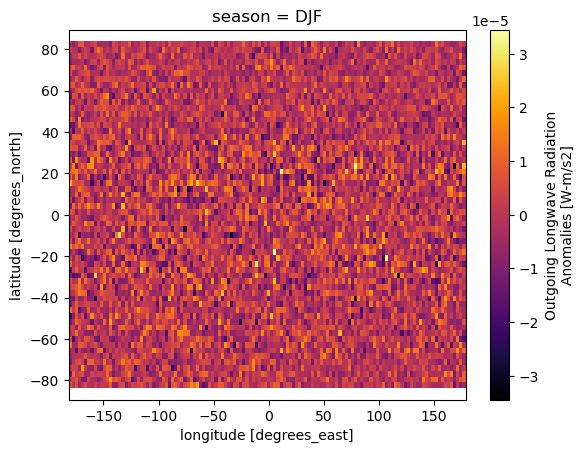

In [142]:
winter_avg_bad.plot(cmap='inferno')

### The correct way to compute seasonal averages with xarray

In [143]:
winter_avg_good = gc.climatology_average(sst, 'season').isel(season=0)
winter_avg_good.plot(cmap='inferno')

TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

## So what's the difference?
It is hard to see the difference between the correct and incorrect ways of caluclating the seasonal averages. If we plot the difference between the two results, the computational errors become easier to see.

In [119]:
diff = winter_avg_good - winter_avg_bad
diff.max()

<xarray.DataArray ()>
array(2.54313151e-06)
Coordinates:
    season   <U3 'DJF'
Attributes:
    valid_range:  [-1.8 35. ]
    units:        deg_C